In [35]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy.table import Table
import scienceplots
from scipy.optimize import fsolve
from mpl_toolkits.mplot3d import Axes3D
plt.style.use(['science','grid','bright'])
%matplotlib inline

In [2]:
G = const.G
pi = np.pi
msun = u.Msun
rsun = u.Rsun
kms = (u.km) / (u.s)
day = u.day

In [3]:
def kick(vkick_min, vkick_max, N):
    """
    Generates kick magnitudes and directions.

    Parameters:
        vkick_min (float): Minimum kick magnitude.
        vkick_max (float): Maximum kick magnitude.
        N (int): Number of samples to generate.

    Returns:
        tuple: 
            - magnitudes (array): Kick magnitudes (size N).
            - directions (array): Array of polar and azimuthal angles (size N x 2).
    """
    # Generate magnitudes uniformly
    vkick_min = vkick_min.to('km/s').value
    vkick_max = vkick_max.to('km/s').value
    magnitudes = np.random.uniform(vkick_min, vkick_max, N) * kms
    
    # Generate isotropic directions
    phi = np.arccos(2 * np.random.uniform(0,1,N) - 1) - pi/2  # Polar angle
    omega = 2 * np.pi * np.random.uniform(0,1,N)          # Azimuthal angle

    # Combine directions
    directions = np.vstack((phi, omega)).T
    
    return magnitudes, directions

def sample_orbital_period(P_min, P_max, N):
    """
    Generates a uniform distribution of orbital periods.

    Parameters:
        P_min (float): Minimum orbital period (days).
        P_max (float): Maximum orbital period (days).
        N (int): Number of samples to generate.

    Returns:
        np.ndarray: Array of sampled orbital periods (size N).
    """
    P_min = P_min.to('day').value
    P_max = P_max.to('day').value
    return np.random.uniform(P_min, P_max, N) * day

def sample_mass_loss(delta_m_min, delta_m_max, N):
    """
    Generates a uniform distribution of mass loss values during the SN.

    Parameters:
        delta_m_min (float): Minimum mass loss (M_sun).
        delta_m_max (float): Maximum mass loss (M_sun).
        N (int): Number of samples to generate.

    Returns:
        np.ndarray: Array of sampled mass loss values (size N).
    """
    delta_m_min = delta_m_min.to('Msun').value
    delta_m_max = delta_m_max.to('Msun').value
    return np.random.uniform(delta_m_min, delta_m_max, N) * msun

def calculate_progenitor_mass(delta_m, M_min):
    """
    Calculates the progenitor mass based on mass loss.

    Parameters:
        delta_m (np.ndarray): Array of mass loss values (M_sun).
        M_min (float): Minimum progenitor mass (M_sun), corresponding to zero mass loss.

    Returns:
        np.ndarray: Array of progenitor masses (size N).
    """
    return M_min + delta_m

def v_orb(primary_mass, secondary_mass, semi_major_axis):
    """
    Computes the orbital velocity.

    Parameters:
        primary_mass (float): Mass of the primary star (kg).
        secondary_mass (float): Mass of the secondary star (kg).
        semi_major_axis (float): Orbital semi-major axis (m).

    Returns:
        float: Orbital velocity (m/s).
    """
    return (np.sqrt(G * (primary_mass + secondary_mass) / semi_major_axis)).to('km/s')

def P_orb(primary_mass, secondary_mass, semi_major_axis):
    """
    Computes the orbital period.

    Parameters:
        primary_mass (float): Mass of the primary star (kg).
        secondary_mass (float): Mass of the secondary star (kg).
        semi_major_axis (float): Orbital semi-major axis (m).

    Returns:
        float: Orbital period (days).
    """
    return (2 * pi * np.sqrt(semi_major_axis**3 / (G * (primary_mass + secondary_mass)))).to('day')

def pre_SN_a(M1, M2, P):
    """
    Computes the orbital period.

    Parameters:
        primary_mass (float): Mass of the primary star (kg).
        secondary_mass (float): Mass of the secondary star (kg).
        semi_major_axis (float): Orbital semi-major axis (m).

    Returns:
        float: Orbital period (days).
    """
    return (((P / (2*pi))**2 * G * (M1 + M2))**(1/3)).to('Rsun')

def m_tilde(pre_sn_primary_mass, post_sn_primary_mass, secondary_mass):
    """
    Computes the ratio of pre- to post-SN total masses.

    Parameters:
        pre_sn_primary_mass (float): Pre-SN mass of the primary star (kg).
        post_sn_primary_mass (float): Post-SN mass of the primary star (kg).
        secondary_mass (float): Mass of the secondary star (kg).

    Returns:
        float: Ratio of pre- to post-SN total masses.
    """
    return (pre_sn_primary_mass + secondary_mass) / (post_sn_primary_mass + secondary_mass)

def v_tilde(kick_velocity, orbital_velocity):
    """
    Computes the scaled kick velocity.

    Parameters:
        kick_velocity (float): Kick velocity (m/s).
        orbital_velocity (float): Orbital velocity (m/s).

    Returns:
        float: Scaled kick velocity.
    """
    return kick_velocity / orbital_velocity

def post_SN_eccentricity(mass_ratio, scaled_kick_velocity, kick_angle_phi, kick_angle_omega):
    """
    Computes the post-SN eccentricity.

    Parameters:
        mass_ratio (float): Ratio of pre- to post-SN total masses.
        scaled_kick_velocity (float): Scaled kick velocity.
        kick_angle_phi (float): Angle between orbital and kick velocity vectors (radians).
        kick_angle_theta (float): Angle between orbital plane and kick velocity vector (radians).

    Returns:
        float: Post-SN eccentricity.
    """
    term1 = 2 - mass_ratio * (1 + 2 * scaled_kick_velocity * np.cos(kick_angle_omega) * np.cos(kick_angle_phi) + scaled_kick_velocity**2)
    term2 = (1 + scaled_kick_velocity * np.cos(kick_angle_omega) * np.cos(kick_angle_phi))**2 + (scaled_kick_velocity * np.sin(kick_angle_phi))**2
    return np.sqrt(1 - mass_ratio * term1 * term2)

def post_SN_semi_major_axis(pre_sn_semi_major_axis, mass_ratio, scaled_kick_velocity, kick_angle_phi, kick_angle_omega):
    """
    Computes the post-SN semi-major axis.

    Parameters:
        pre_sn_semi_major_axis (float): Pre-SN semi-major axis (m).
        mass_ratio (float): Ratio of pre- to post-SN total masses.
        scaled_kick_velocity (float): Scaled kick velocity.
        kick_angle_phi (float): Angle between orbital and kick velocity vectors (radians).
        kick_angle_theta (float): Angle between orbital plane and kick velocity vector (radians).

    Returns:
        float: Post-SN semi-major axis (m).
    """
    term1 = 2 - mass_ratio * (1 + 2 * scaled_kick_velocity * np.cos(kick_angle_omega) * np.cos(kick_angle_phi) + scaled_kick_velocity**2)
    return pre_sn_semi_major_axis / term1

def post_SN_system_velocity(pre_sn_primary_mass, post_sn_primary_mass, secondary_mass, orbital_velocity, scaled_kick_velocity, kick_angle_phi, kick_angle_omega):
    """
    Computes the post-SN systemic velocity of the binary system.

    Parameters:
        pre_sn_primary_mass (float): Pre-SN mass of the primary star (kg).
        post_sn_primary_mass (float): Post-SN mass of the primary star (kg).
        secondary_mass (float): Mass of the secondary star (kg).
        orbital_velocity (float): Initial orbital velocity (m/s).
        scaled_kick_velocity (float): Scaled kick velocity.
        kick_angle_phi (float): Angle between orbital and kick velocity vectors (radians).
        kick_angle_theta (float): Angle between orbital plane and kick velocity vector (radians).

    Returns:
        float: Post-SN systemic velocity (m/s).
    """
    reduced_mass = (pre_sn_primary_mass * secondary_mass) / (pre_sn_primary_mass + secondary_mass)  # Reduced mass
    delta_primary_mass = pre_sn_primary_mass - post_sn_primary_mass  # Mass lost during SN
    
    term1 = (reduced_mass * delta_primary_mass / pre_sn_primary_mass)**2
    term2 = -2 * (reduced_mass * delta_primary_mass * post_sn_primary_mass / pre_sn_primary_mass) * scaled_kick_velocity * np.cos(kick_angle_omega) * np.cos(kick_angle_phi)
    term3 = (post_sn_primary_mass * scaled_kick_velocity)**2
    system_velocity = (orbital_velocity / (post_sn_primary_mass + secondary_mass)) * np.sqrt(term1 + term2 + term3)
    
    return system_velocity

In [104]:
np.random.seed(1234)
N = int(1e4)

M1 = 12 * msun
M2 = 6 * msun

P_min, P_max = 5 * day, 5 * day
period = sample_orbital_period(P_min, P_max, N)

delta_m_min, delta_m_max = 0 * msun, M1
delta_m = sample_mass_loss(delta_m_min, delta_m_max, N)

vkick_min, vkick_max =20 * kms, 20 * kms
speed, angles = kick(vkick_min, vkick_max, N)
phi = angles[:,0]
omega = angles[:,1]

M1_prime = M1 - 8*msun#delta_m

a = pre_SN_a(M1, M2, period)
vorb = v_orb(M1, M2, a)

mtilde = m_tilde(M1, M1_prime, M2)
vtilde = v_tilde(speed, vorb)
e = post_SN_eccentricity(mtilde, vtilde, phi, omega)
vsys = post_SN_system_velocity(M1, M1_prime, M2, vorb, vtilde, phi, omega)
final_a = post_SN_semi_major_axis(a, mtilde, vtilde, phi, omega)
final_period = P_orb(M1_prime, M2, final_a)

/Users/neevshah/anaconda3/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [105]:
# Create the Astropy table with units preserved
table = Table(
    {
        #"m1_f": M1_prime,           # M1 with units (e.g., Msun)# Orbital velocity with units (e.g., km/s)
        "kick": speed,      # Kick speed with units (e.g., km/s)
        "phi": phi,     # Kick angle theta (radians)
        "omega": omega,         # Kick angle phi (radians)
        "e": e,             # Post-SN eccentricity (dimensionless)
        "v_sys": vsys,      # Systemic velocity with units (e.g., km/s)
        "final_a": final_a,
        "final_period": final_period
    }
)

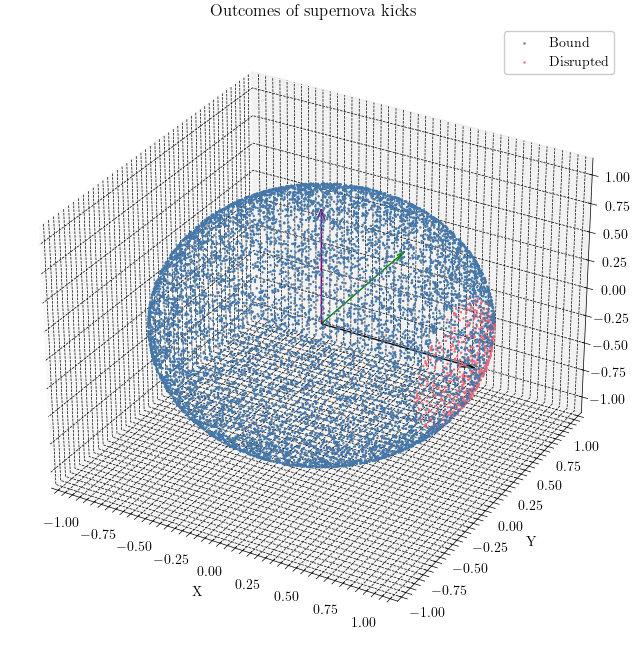

In [121]:
# Example data setup
phi_bound = table[table['e'] < 1]['phi']  # Polar angle (-pi/2 to pi/2)
omega_bound = table[table['e'] < 1]['omega']  # Azimuthal angle (0 to 2*pi)
phi_disrupted = table[table['e'] > 1]['phi']
omega_disrupted = table[table['e'] > 1]['omega']

# Conversion to Cartesian coordinates
def polar_to_cartesian(phi, omega):
    x = np.cos(phi) * np.cos(omega)
    y = np.cos(phi) * np.sin(omega)
    z = np.sin(phi)
    return x, y, z

# Bound objects
x_bound, y_bound, z_bound = polar_to_cartesian(phi_bound, omega_bound)
# Disrupted objects
x_disrupted, y_disrupted, z_disrupted = polar_to_cartesian(phi_disrupted, omega_disrupted)

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for Bound and Disrupted
ax.scatter(x_bound, y_bound, z_bound, label='Bound', alpha=1, s = 0.5, rasterized = True)
ax.scatter(x_disrupted, y_disrupted, z_disrupted, label='Disrupted', alpha=1, s = 0.5, rasterized = True)



# Add axes for x, y, and z
ax.quiver(0, 0, 0, 1, 0, 0, color='black', arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, 1, 0, color='green', arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, 0, 1, color='purple', arrow_length_ratio=0.1)

# Labels and legends
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title('Outcomes of supernova kicks')
plt.savefig('SN_kick_direction_outcomes.png', dpi = 300)
